<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B28_4%5D_Deep_Dream_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# DeepDream 

DeepDream adalah eksperimen yang memvisualisasikan pola yang dipelajari oleh jaringan saraf. Mirip dengan ketika seorang anak menonton awan dan mencoba untuk menafsirkan bentuk acak, DeepDream over-interpretasi dan meningkatkan pola yang dilihatnya dalam gambar.

Proses ini dilakukan dengan meneruskan gambar melalui jaringan, kemudian menghitung gradien gambar sehubungan dengan aktivasi lapisan tertentu. Gambar kemudian dimodifikasi untuk meningkatkan aktivasi ini, meningkatkan pola yang dilihat oleh jaringan, dan menghasilkan gambar seperti mimpi. 

Proses ini dijuluki "Inceptionism" (referensi ke InceptionNet, dan Inception film).

Mari kita tunjukkan bagaimana Anda bisa membuat jaringan saraf "mimpi" dan meningkatkan pola nyata yang dilihatnya dalam gambar.

## Import Modul

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import scipy
import argparse

from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (15, 15)


Using TensorFlow backend.


## Siapkan Gambar Konten

Pada contoh kali ini, kita akan gunakan gambar pemandangan tebing gunung Pilatus

114688/108340 [===============================] - 0s 0us/step


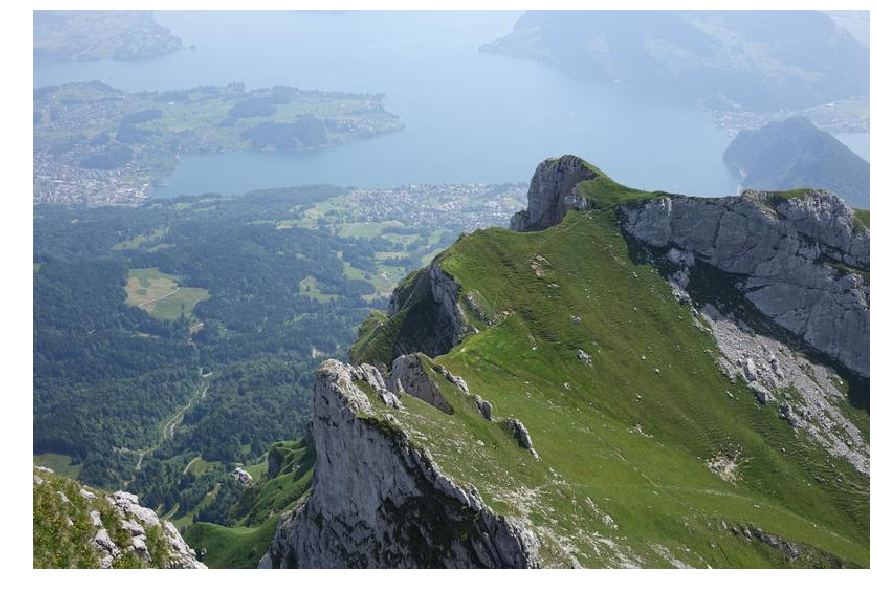

In [2]:
url = 'https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg'

image_path = keras.utils.get_file('myImage.jpg', origin=url)
original_img = keras.preprocessing.image.load_img(image_path)
plt.imshow(original_img)
plt.axis('off')
plt.show()

## Download Inception Model
Untuk contoh kali ini, kita gunakan model InceptionV3

In [3]:
base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet')
dream = base_model.input

W0807 03:20:08.595604 139656663943040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 03:20:08.616902 139656663943040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 03:20:08.620131 139656663943040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 03:20:08.640769 139656663943040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 03:20:08.641546 1396566639

87916544/87910968 [==============================] - 4s 0us/step


Daftar nama layer yang ada di dalam InceptionV3 dapat dilihat jika mengaktifkan cell di bawah

daftar nama tersebut bisa dipilih sebagai layer yang akan menghalusinasi gambar

In [5]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Preproses Gambar

Praproses gambar agar sesuai dengan model InceptionV3

In [0]:
img = keras.preprocessing.image.img_to_array(original_img)
img = np.expand_dims(img, axis=0)
img = keras.applications.inception_v3.preprocess_input(img)

## Pilih Layer DeepDream

Gagasan dalam DeepDream adalah untuk memilih lapisan (atau lapisan) dan memaksimalkan "loss" agar gambar semakin "mengaktivasi" layer yang dipilih. Kompleksitas fitur yang dimasukkan tergantung pada lapisan yang dipilih

Layer di awal jaringan menghasilkan goresan atau pola sederhana, sementara lapisan yang lebih dalam memberikan fitur kompleks dalam gambar, atau bahkan seluruh objek.

Di sini, kita pilih dan definisikan layer-layer mana saja yang akan digunakan untuk memberikan halusinasi pada gambar

In [0]:
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])

settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 2.,
        'mixed4': 4,
        'mixed5': 1.5,
    },
}

## Helper Function
Fungsi bantuan untuk menghitung loss DeepDream dan memproses gambar output

In [16]:
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling
      
      
# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x
  

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

W0807 03:22:31.319980 139656663943040 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


## Gradient Ascent
Fungsi optimasi Gradient Ascent untuk menjalankan proses DeepDream

Menambahkan gradien ke gambar meningkatkan pola yang dilihat oleh jaringan. Pada setiap langkah, kita akan menciptakan gambar yang semakin mengaktivasi layer yang dipilih dalam jaringan.

In [0]:
K.set_learning_phase(0)


outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


In [0]:

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
  
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        x += step * grad_values
    
    print('Loss :', loss_value)
    return x

## Mulai Optimasi
Di sini, mari kita mulai optimasi DeepDream selama 20 iterasi

Ubah-ubahlah Hyperparameter ini untuk mendapatkan efek yang baru

In [0]:
step = 0.01         # Gradient ascent step size
num_octave = 3      # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20     # Number of ascent steps per scale
max_loss = 10.

Processing image shape (271.0, 407.0)
Loss : 10.867802


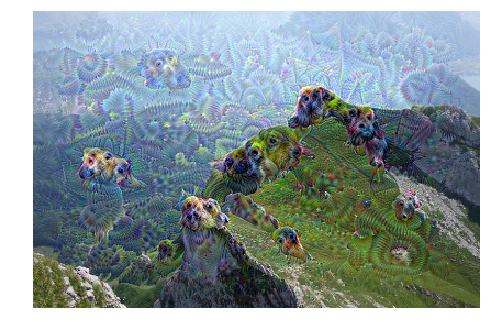

Processing image shape (380.0, 570.0)
Loss : 11.355559


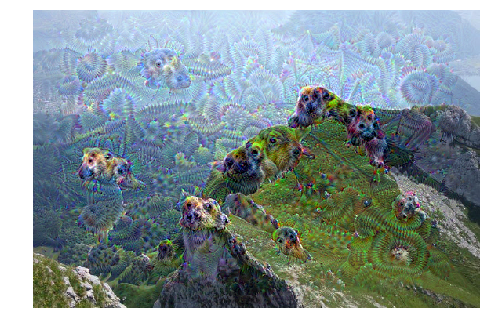

Processing image shape (533, 799)
Loss : 10.657825


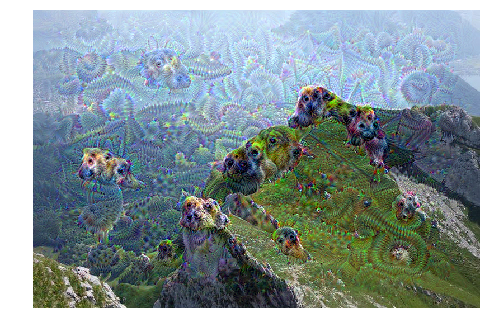



Final Result


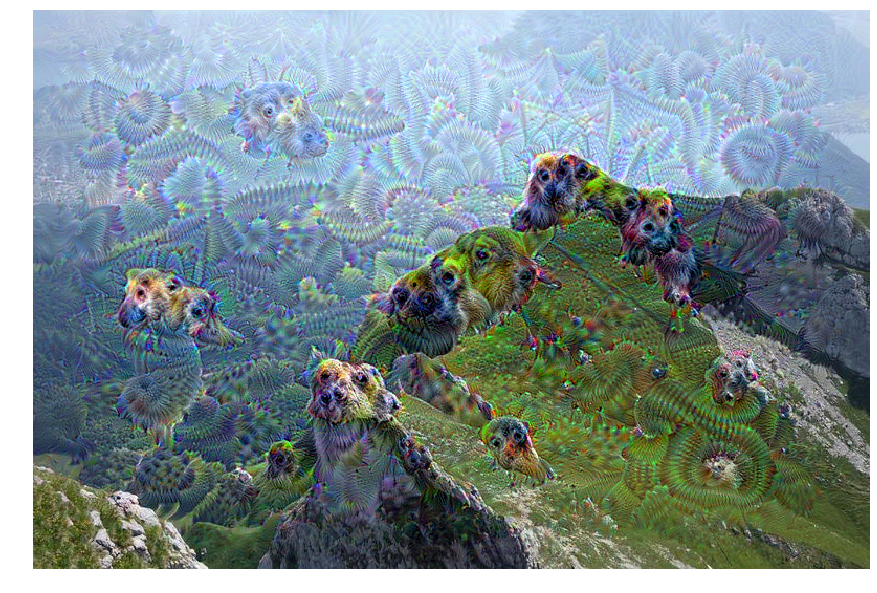

In [20]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim) // (octave_scale ** i) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)    
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    
    plt.imshow(deprocess_image(np.copy(img)))
    plt.axis('off')
    plt.show()
    
    shrunk_original_img = resize_img(original_img, shape)



print('\n\nFinal Result')
mpl.rcParams['figure.figsize'] = (15, 15)
plt.imshow(deprocess_image(np.copy(img)))
plt.axis('off')
plt.show()

Bagaimana hasil DeepDream-nya?

Nyenyak?

Cobalah ubah menggunakan layer yang lain

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>